# 1. Load Data

In [1]:
from itertools import combinations

In [5]:
import json, string

In [11]:
import pandas as pd

In [36]:
import matplotlib.pyplot as plt

<b>1.1 Load data from json files</b>

In [6]:
data_dict = {}
data_list = ['access','disk','user']

for item in data_list:
    with open(f'tickets_dataset/{item}_tickets.json', 'r') as file:
       print(f'load {item}_tickets.json')
       data_dict[item] = json.load(file)

load access_tickets.json
load disk_tickets.json
load user_tickets.json


In [7]:
key_phrase_stats = {}

for item in data_list:
    for rec in data_dict[item]:
        key_phrase = rec['key_phrase']
        if key_phrase in key_phrase_stats:
            key_phrase_stats[key_phrase] += 1
        else:
            key_phrase_stats[key_phrase] = 1

key_phrase_stats

{'grant access': 7,
 'revoke access': 7,
 'access profile': 6,
 'disk space': 8,
 'disk full': 5,
 'disk error': 7,
 'add user': 5,
 'delete user': 5,
 'create user': 5,
 'modify user': 5}

In [8]:
def json_to_df(json_dict, label=None):
    cols = list(json_dict[0].keys())

    cols_values = {item:[] for item in cols}
    for json_rec in json_dict:
        for item in cols:
            cols_values[item].append(json_rec[item])

    if label is not None:
        cols += ['label']
        cols_values[cols[-1]] = len(json_dict)*[label]
    
    return pd.DataFrame({item:cols_values[item] for item in cols})
    

In [12]:
tickets_df = json_to_df(data_dict[data_list[0]],
                        label=0)
k = 1
for item in data_list[1:]:
    tickets_df = pd.concat([tickets_df,
                            json_to_df(data_dict[item],
                                       label=k)]
                          )
    k += 1
tickets_df = tickets_df.reset_index()
tickets_df = tickets_df[tickets_df.columns[1:]]
#tickets_df = tickets_df.drop(['index'])

In [13]:
tickets_df.head()

,subject,description,key_phrase,label
0,Grant Access to Confidential Files,Grant user access to confidential documents.,grant access,0
1,Revoke Access to Sensitive Data,Revoke user access to sensitive information.,revoke access,0
2,Update Access Profile,Modify my access profile to include admin rights,access profile,0
3,Grant Access Request for New Project,Please grant access to project files for users...,grant access,0
4,Access Removal for Departing Employee,Revoke access for departing employee.,revoke access,0


<b>1.2 Load data using HuggingFace dataset</b>

In [14]:
from datasets import load_dataset
support_tickets = load_dataset("phi-ai-info/support_tickets")

In [15]:
support_tickets['train'][0]

{'subject': 'Grant Access to Confidential Files',
 'description': 'Grant user access to confidential documents.',
 'key_phrase': 'grant access'}

In [16]:
def dataset_to_df(dataset_obj, 
                  label=None):
    cols = list(dataset_obj[0].keys())
    labels = []

    cols_values = {item:[] for item in cols}
    for json_rec in dataset_obj:
        for item in cols:
            cols_values[item].append(json_rec[item])
    
    if label is not None:
        new_key = 'label'
        cols += [new_key]
        cols_values[new_key] = []
        for json_rec in dataset_obj:
            cols_values[new_key].append(label[json_rec['key_phrase']])
    
    return pd.DataFrame({item:cols_values[item] for item in cols})

In [17]:
label_dict = {'grant access': 0,
 'revoke access': 0,
 'access profile': 0,
 'disk space': 1,
 'disk full': 1,
 'disk error': 1,
 'add user': 2,
 'delete user': 2,
 'create user': 2,
 'modify user': 2}

df_set = dataset_to_df(support_tickets['train'], 
                       label=label_dict)

In [18]:
df_set.head()

,subject,description,key_phrase,label
0,Grant Access to Confidential Files,Grant user access to confidential documents.,grant access,0
1,Revoke Access to Sensitive Data,Revoke user access to sensitive information.,revoke access,0
2,Update Access Profile,Modify my access profile to include admin rights,access profile,0
3,Grant Access Request for New Project,Please grant access to project files for users...,grant access,0
4,Access Removal for Departing Employee,Revoke access for departing employee.,revoke access,0


<b>1.3 Sanity check: compare dataframe load using different methods</b>

In [19]:
assert tickets_df.shape == df_set.shape
assert all(tickets_df.columns == df_set.columns)
for col in tickets_df.columns:
    all(tickets_df[col] == df_set[col])
#assert tickets_df.shape == df_set.shape
#assert tickets_df.shape == df_set.shape

# 2.1 Preprocess data

In [20]:
tickets_df.head()

,subject,description,key_phrase,label
0,Grant Access to Confidential Files,Grant user access to confidential documents.,grant access,0
1,Revoke Access to Sensitive Data,Revoke user access to sensitive information.,revoke access,0
2,Update Access Profile,Modify my access profile to include admin rights,access profile,0
3,Grant Access Request for New Project,Please grant access to project files for users...,grant access,0
4,Access Removal for Departing Employee,Revoke access for departing employee.,revoke access,0


<b>2.1 Load stop words</b>

In [21]:
import nltk
from nltk.corpus import stopwords
 
nltk.download('stopwords')

stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\18623\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<b>2.2 Load lemmatizer</b>

In [22]:
from nltk.stem import WordNetLemmatizer
 
lemmatizer = WordNetLemmatizer()

s = "approve user access to confidential documents"
print(f"{s} :", lemmatizer.lemmatize(s))
print("corpora :", lemmatizer.lemmatize("corpora"))
 
# a denotes adjective in "pos"
print("better :", lemmatizer.lemmatize("better", pos="a"))

approve user access to confidential documents : approve user access to confidential documents
corpora : corpus
better : good


<b>2.3 Create preprocessing routine</b>

In [23]:
def preprocess_text(s,
                    stop_words=None,
                    lemmatizer=None
                   ):
    s = s.translate({ord(i): None for i in string.punctuation})
    s = s.lower()

    text = s

    if stop_words is not None:
        s_list = text.split(' ')
        #print(f's_list in {s_list}')
        keep_list = []
        for item in s_list:
            if item in stop_words:
                continue
            keep_list.append(item)
        text = ' '.join(keep_list)

    if lemmatizer is not None:
        #print('Lemmatizer is enabled')
        s_list = text.split(' ')
        keep_list = []
        for item in s_list:
            item = lemmatizer.lemmatize(item)
            keep_list.append(item)
        text = ' '.join(keep_list)
        
    return text 

In [24]:
s = "approve user access to confidential documents"
preprocess_text(s,
                stop_words=stop_words,
                lemmatizer=None)

'approve user access confidential documents'

In [25]:
s = "approve user access to confidential documents"
preprocess_text(s,
                stop_words=stop_words,
                lemmatizer=lemmatizer)

'approve user access confidential document'

<b>2.4 Preprocessing dataframe</b>

In [26]:
tickets_df['preproc_description'] = tickets_df['description'].apply(lambda text: preprocess_text(text,stop_words=stop_words,lemmatizer=lemmatizer))

In [27]:
tickets_df['preproc_subject'] = tickets_df['subject'].apply(lambda text: preprocess_text(text,stop_words=stop_words,lemmatizer=lemmatizer))

In [28]:
tickets_df.head()

,subject,description,key_phrase,label,preproc_description,preproc_subject
0,Grant Access to Confidential Files,Grant user access to confidential documents.,grant access,0,grant user access confidential document,grant access confidential file
1,Revoke Access to Sensitive Data,Revoke user access to sensitive information.,revoke access,0,revoke user access sensitive information,revoke access sensitive data
2,Update Access Profile,Modify my access profile to include admin rights,access profile,0,modify access profile include admin right,update access profile
3,Grant Access Request for New Project,Please grant access to project files for users...,grant access,0,please grant access project file user team,grant access request new project
4,Access Removal for Departing Employee,Revoke access for departing employee.,revoke access,0,revoke access departing employee,access removal departing employee


# 3. Transform text: embedding, dim reduction

<b>3.0 Import LLM library</b>

In [29]:
import warnings
from sentence_transformers import SentenceTransformer
warnings.filterwarnings("ignore")

<b>3.1 Create embeddings for preprocessed description</b>

In [30]:
phrase_model = SentenceTransformer('whaleloops/phrase-bert')

In [31]:
#conver df column to list
preproc_desc = tickets_df['preproc_description'].to_list() 	

In [32]:
embeds = phrase_model.encode(preproc_desc)

In [33]:
embeds.shape

(60, 768)

<b>3.2 Do dim reduction for embeddings</b>

In [34]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2,normalized_stress='auto')
X_transformed = embedding.fit_transform(embeds)
X_transformed.shape

(60, 2)

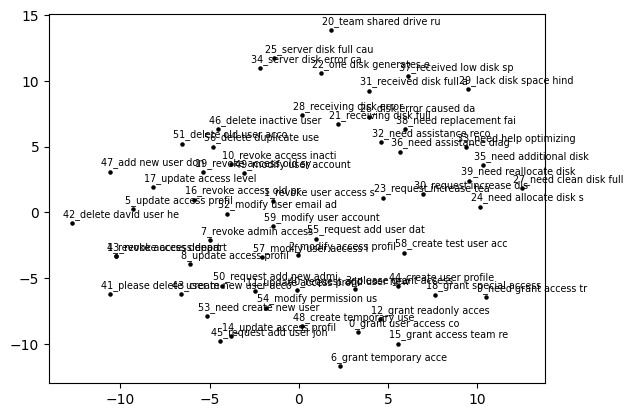

In [37]:
for ind in range(X_transformed.shape[0]):
    plt.scatter(X_transformed[ind,0],
                X_transformed[ind,1],
                marker='o',color='black',s=5)
    plt.text(X_transformed[ind,0]-0.5,
             X_transformed[ind,1]+0.5,
             str(ind)+'_'+preproc_desc[ind][:20],
             fontsize='x-small'
            )

# 4. K-means Clustering of Description

<b>4.1 Create centroids</b> 

In [38]:
import numpy as np
centroid_dict = {
    0: np.array([4.5626217, -0.4242633]),
    1: np.array([-2.5, 5]),
    2: np.array([-5, -5]),
}

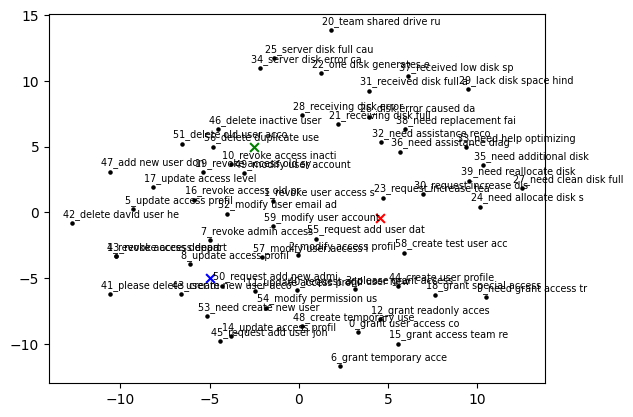

In [39]:
import matplotlib.pyplot as plt
cent_color = ['red','green','blue']
for key in centroid_dict.keys():
    plt.scatter(centroid_dict[key][0],
                centroid_dict[key][1],
                color=cent_color[key],marker='x',s=40)
for ind in range(X_transformed.shape[0]):
    plt.scatter(X_transformed[ind,0],
                X_transformed[ind,1],
                marker='o',color='black',s=5)
    plt.text(X_transformed[ind,0]-0.5,
             X_transformed[ind,1]+0.5,
             str(ind)+'_'+preproc_desc[ind][:20],
             fontsize='x-small'
            )

<b>4.2 Create auxiliary data structures for K-means clustering</b>

In [40]:
import scipy
centroids_in_time = {}
clusters_in_time = {}

centroids_in_time[-1] = centroid_dict.copy() 
centroid_in_time = {0:[],1:[],2:[]}

#centroid_dict = {
#    0: np.array([4.5626217, -0.42426333]),
#    1: np.array([-2.83849683, 3.52663421]),
#    2: np.array([0.69558755, 0.3919084]),
#}
for cent_key in centroid_in_time.keys():
    centroid_in_time[cent_key].append(centroid_dict[cent_key].copy())

centroid_difference_in_time = {}
for i in range(3):
    centroid_difference_in_time[i] = []

<b>4.3 Run K-means clustering</b>

In [41]:
iters = 5
for iter_num in range(iters):
    print(f"------------ Iteration {iter_num} -------------")

    #print(">>>>>> Step 1: Assign Data Point to Clusters")
    #Step 1: cluster assigment step
    cluster_dict = {}
    for j,data_point in enumerate(X_transformed):
        #print(j,' ------ data_point',data_point)
        cent_dist = np.array([])
        for center in centroid_dict.keys():
            #print('centroid',center,centroid_dict[key])
            dist = scipy.spatial.distance.euclidean(data_point,centroid_dict[center])
            cent_dist = np.append(cent_dist,dist)
        cent_dist =  np.sqrt(cent_dist)
        #print(cent_dist)
        cluster_index = np.argmin(cent_dist)
        #print('Cluster index',cluster_index)
        if cluster_index in cluster_dict:
            cluster_dict[cluster_index].append(j)
        else:
            cluster_dict[cluster_index] = [j]
            
    clusters_in_time[iter_num] = cluster_dict.copy()

    #print(">>>>>> Step 2: Update centroids")
    #Step 2: centroid update step
    stop_check_array = []
    for cluster_key in cluster_dict:
        cluster_items = cluster_dict[cluster_key]
        cluster_items = np.array(cluster_items).astype(int)
        
        new_centroid = X_transformed[cluster_items].mean(axis=0)

        centroid_in_time[cluster_key].append(new_centroid.copy())

        distance_between_old_new_centroid = scipy.spatial.distance.euclidean(new_centroid,centroid_dict[cluster_key])
        stop_check_array.append(distance_between_old_new_centroid)

        #print(f"old centroid {cluster_key}: {centroid_dict[cluster_key]} new centroid {cluster_key}: {new_centroid}")
        centroid_dict[cluster_key] = new_centroid.copy()
        centroids_in_time[iter_num] = centroid_dict.copy()   

    for time_key in centroid_difference_in_time:
        centroid_difference_in_time[time_key] += [stop_check_array[time_key]]

    stop_check_array = np.sqrt(stop_check_array)
    #print(stop_check_array)

    #is_stop = True
    #for diff in stop_check_array:
    #    if diff > 0.001:
    #        is_stop = False
    #        break

    #if is_stop:
    #    print(f'>>>>> Training stopped @ iteration {iter_num}')
    #    iters = iter_num
    #    break

------------ Iteration 0 -------------
------------ Iteration 1 -------------
------------ Iteration 2 -------------
------------ Iteration 3 -------------
------------ Iteration 4 -------------


In [42]:
cluster_dict

{2: [0,
  1,
  2,
  4,
  5,
  6,
  7,
  8,
  11,
  13,
  14,
  16,
  17,
  40,
  41,
  42,
  43,
  45,
  47,
  48,
  50,
  52,
  53,
  54,
  55,
  57,
  59],
 0: [3, 9, 12, 15, 18, 23, 24, 27, 29, 30, 33, 35, 36, 38, 39, 44, 58],
 1: [10, 19, 20, 21, 22, 25, 26, 28, 31, 32, 34, 37, 46, 49, 51, 56]}

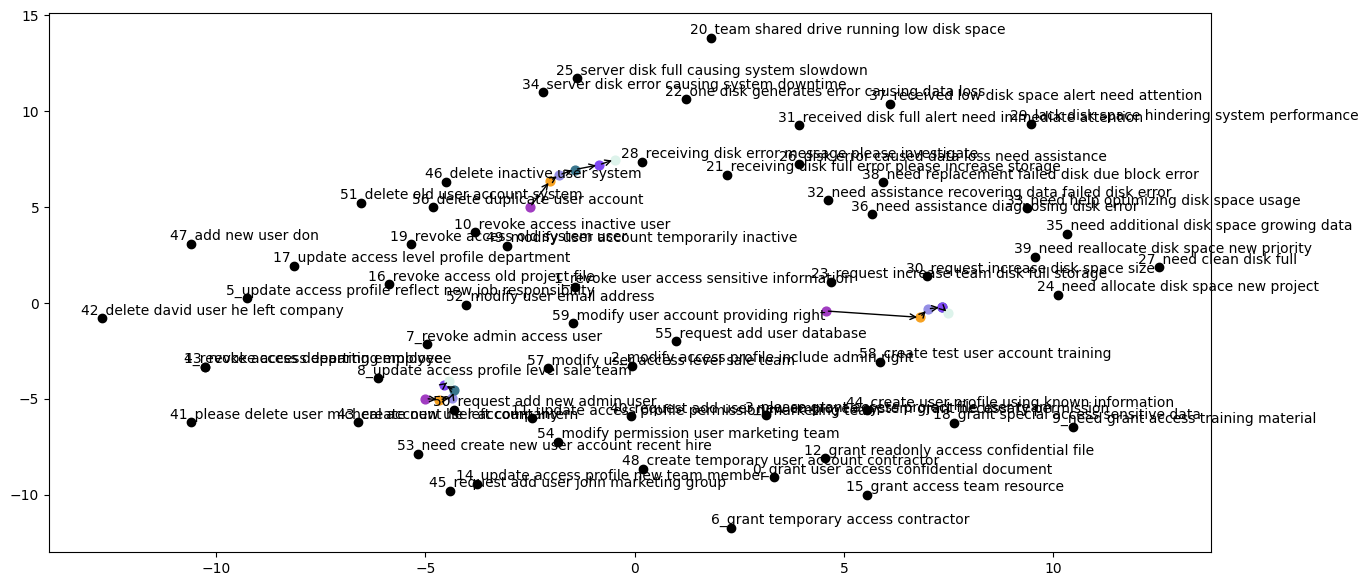

In [43]:
import random
r = lambda: random.randint(0,255)

def random_color():
    return '#%02X%02X%02X'%(r(),r(),r())

import matplotlib.pyplot as plt

iter_color = ['red','green','blue','cyan']
iter_color = []
for iter_num in range(-1,iters):
    iter_color.append(random_color())

pairs = preproc_desc

plt.figure(figsize=(15,7))
for iter_num in range(-1,iters):
    #print('Iter num',iter_num)
    centroid_dict = centroids_in_time[iter_num]
    for j in centroid_dict.keys():
        plt.scatter(centroid_dict[j][0],centroid_dict[j][1],color=iter_color[iter_num],marker='o',s=40)
        #plt.text(centroid_dict[j][0]-0.5,centroid_dict[j][1]+0.2,str(j)+'_centroid_'+str(iter_num))

for key in centroid_in_time:
    centroid_list = centroid_in_time[key]
    #print(len(centroid_list))
    for i in range(len(centroid_list)-1):
        #print(i)
        plt.annotate('',
                     xy=(centroid_list[i+1][0],centroid_list[i+1][1]),
                     xytext=(centroid_list[i][0],centroid_list[i][1]),
                     arrowprops = dict(arrowstyle='->',color='black')
                    )

for i in range(X_transformed.shape[0]):
    plt.scatter(X_transformed[i,0],X_transformed[i,1],marker='o',color="black")
    plt.text(X_transformed[i,0]-0.5,X_transformed[i,1]+0.2, str(i)+"_"+pairs[i])

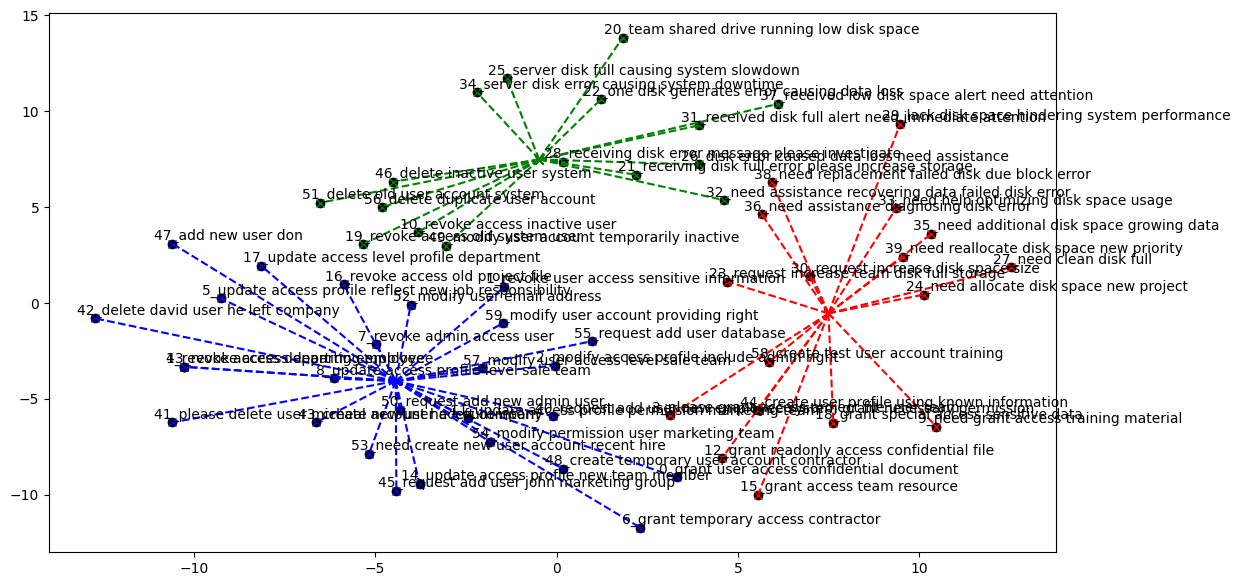

In [44]:
plt.figure(figsize=(13,7))

for i in range(X_transformed.shape[0]):
    plt.scatter(X_transformed[i,0],X_transformed[i,1],marker='o',color="black")
    plt.text(X_transformed[i,0]-0.5,X_transformed[i,1]+0.2, str(i)+"_"+pairs[i])

clust_colors = ['red','green','blue']
for clust_key in cluster_dict.keys():
    cluster_list = cluster_dict[clust_key]
    for item in cluster_list:
        plt.plot([centroid_dict[clust_key][0],X_transformed[item,0]],
                 [centroid_dict[clust_key][1],X_transformed[item,1]],
                 color=clust_colors[clust_key],
                 linestyle='dashed',
                 marker='x')

In [45]:
labels = tickets_df['label'].to_list()

label_count_by_cluster = {i:{i:0 for i in [0,1,2]} for i in [0,1,2]}

for key in cluster_dict.keys():
    print(f"------ Cluster {key} ------")
    for item in cluster_dict[key]:
        print(preproc_desc[item],labels[item])
        label_count_by_cluster[key][labels[item]] += 1    

------ Cluster 2 ------
grant user access confidential document 0
revoke user access sensitive information 0
modify access profile include admin right 0
revoke access departing employee 0
update access profile reflect new job responsibility 0
grant temporary access contractor 0
revoke admin access user 0
update access profile level sale team 0
update access profile permission marketing team 0
revoke access departing employee 0
update access profile new team member 0
revoke access old project file 0
update access level profile department 0
request add user new employee system grant necessary permission 2
please delete user micheal account he left company 2
delete david user he left company 2
create new user account intern 2
request add user john marketing group 2
add new user don 2
create temporary user account contractor 2
request add new admin user 2
modify user email address 2
need create new user account recent hire 2
modify permission user marketing team 2
request add user database

In [46]:
label_count_by_cluster

{0: {0: 5, 1: 10, 2: 2}, 1: {0: 2, 1: 10, 2: 4}, 2: {0: 13, 1: 0, 2: 14}}

In [47]:
for key in label_count_by_cluster.keys():
    lab_distrib = np.array(list(label_count_by_cluster[key].values()))
    norm_freq = lab_distrib/lab_distrib.sum()
    print(f'Cluster {key} contains label 0: {norm_freq[0]*100:.2f}% label 1: {norm_freq[1]*100:.2f}% label 2: {norm_freq[2]*100:.2f}%')

Cluster 0 contains label 0: 29.41% label 1: 58.82% label 2: 11.76%
Cluster 1 contains label 0: 12.50% label 1: 62.50% label 2: 25.00%
Cluster 2 contains label 0: 48.15% label 1: 0.00% label 2: 51.85%


# 5. Create 2-grams (pairs)

In [48]:
combs = combinations(s.split(' '),2)
for item in combs:
    print(item)

('approve', 'user')
('approve', 'access')
('approve', 'to')
('approve', 'confidential')
('approve', 'documents')
('user', 'access')
('user', 'to')
('user', 'confidential')
('user', 'documents')
('access', 'to')
('access', 'confidential')
('access', 'documents')
('to', 'confidential')
('to', 'documents')
('confidential', 'documents')


In [49]:
def collect_unique_pairs(pair_dict,
                         s,
                         stop_words=[]
                        ):
    s = s.translate({ord(i): None for i in string.punctuation})
    s = s.lower()
    combs = combinations(s.split(' '),2)
    key_list = []
    for item in combs:
        contains_stop_word = False
        for word in item:
            if word in stop_words:
                contains_stop_word = True
                break
        if contains_stop_word:
            continue
        key_list.append(item)
        if item in pair_dict:
            pair_dict[item] += 1
        else:
            pair_dict[item] = 1
    return pair_dict, key_list

In [50]:
proc_desc = tickets_df['preproc_description'].to_list()
labels = tickets_df['label'].to_list()

pair_dict = {}
pair_origin = {}

item = 'tickets'

for k, rec in enumerate(proc_desc):
    pair_dict, collected_keys = collect_unique_pairs(pair_dict,
                                                     rec)
    for key in collected_keys:
        if key in pair_origin:
            pair_origin[key].append((item,k))
        else:
            pair_origin[key] = [(item,k)]

In [51]:
#pair_dict

In [52]:
#pair_origin

# Analize Pairs

In [116]:
len(proc_desc)

60

In [117]:
len(pair_dict)

579

In [118]:
len(pair_origin)

579

In [119]:
#sort dictionary keys in descending order from max val to min
pair_dict = {k: v for k, v in sorted(pair_dict.items(), key=lambda item: item[1], reverse=True)}

In [120]:
#pair_dict

In [121]:
ideal_pairs = ['grant access','revoke access','access profile','disk space','disk error','disk full','add user','delete user','modify user','create user']

for item in ideal_pairs:
    s_list = item.split(' ')
    print(item,pair_dict[(s_list[0],s_list[1])])

grant access 7
revoke access 7
access profile 6
disk space 8
disk error 8
disk full 5
add user 5
delete user 5
modify user 5
create user 5


In [122]:
threshold = 4

pair_dict_short = []
for item in pair_dict:
    if pair_dict[item] > threshold:
        pair_dict_short.append(item)

In [123]:
len(pair_dict)

579

In [124]:
len(pair_dict_short)

15

In [125]:
def count_coverage(pair_list, 
                   pair_origin,
                   data_list=['tickets'],
                   lng = 60
                  ):
    coverage_dict = {}
    for item in data_list:
        coverage_dict[item] = [] 
  
    for pair in pair_list:
        #print(pair)
        origin = pair_origin[pair]
        #print(origin)
        for org in origin:
            coverage_dict[org[0]].append(org[1])

    #print(coverage_dict.keys())
    coverage_score = {}
    for item in data_list:
        unique_samples = set(sorted(coverage_dict[item]))
        #print(item, unique_samples)
        coverage_score[item] = len(unique_samples)/lng
   
    return coverage_dict, coverage_score   

In [126]:
coverage_dict, coverage_score = count_coverage(pair_dict_short, 
                                               pair_origin)


In [127]:
coverage_score

{'tickets': 1.0}

# 6. K-means clustering with pairs (2-grams)

In [128]:
import warnings
from sentence_transformers import SentenceTransformer
warnings.filterwarnings("ignore")

<b>6.0 Review pairs</b>

In [129]:
word_pairs = [ f'{item[0]} {item[1]}' for item in pair_dict_short]

In [130]:
word_pairs

['user account',
 'disk space',
 'disk error',
 'need disk',
 'grant access',
 'revoke access',
 'access profile',
 'access team',
 'update access',
 'update profile',
 'disk full',
 'add user',
 'delete user',
 'create user',
 'modify user']

<b>6.1 Create pair embeddings</b>

In [131]:
phrase_model = SentenceTransformer('whaleloops/phrase-bert')

In [132]:
embeds = phrase_model.encode(word_pairs)

<b>6.2 Do dim reduction for pair embeddings</b>

In [133]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2,normalized_stress='auto')
X_transformed = embedding.fit_transform(embeds)
X_transformed.shape

(15, 2)

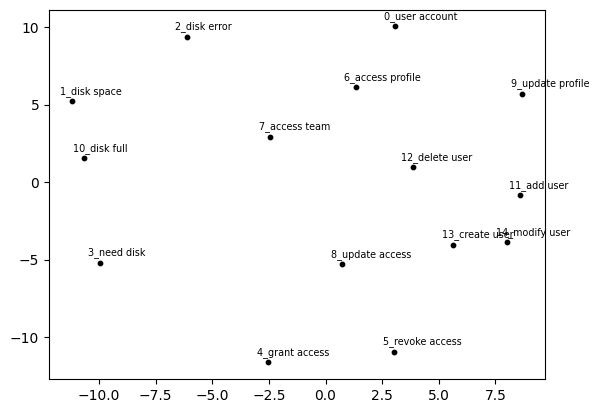

In [134]:
for ind in range(X_transformed.shape[0]):
    plt.scatter(X_transformed[ind,0],
                X_transformed[ind,1],
                marker='o',color='black',s=10)
    plt.text(X_transformed[ind,0]-0.5,
             X_transformed[ind,1]+0.5,
             str(ind)+'_'+word_pairs[ind],
             fontsize='x-small'
            )

<b>6.3 K-means clustering</b>

In [135]:
import numpy as np
centroid_dict = {
    0: np.array([4.5626217, -0.4242633]),
    1: np.array([-7.5, 0]),
    2: np.array([0.69558755, 5]),
}

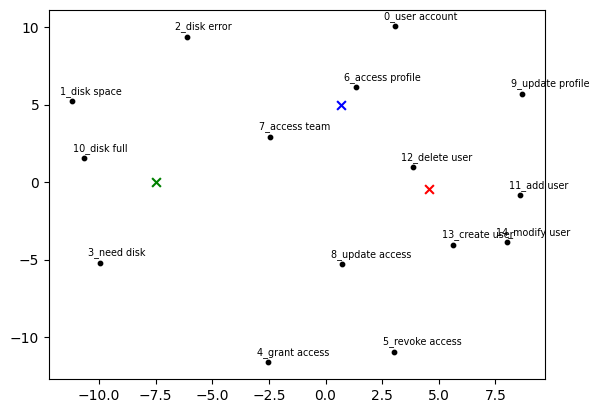

In [136]:
import matplotlib.pyplot as plt
cent_color = ['red','green','blue']
for key in centroid_dict.keys():
    plt.scatter(centroid_dict[key][0],
                centroid_dict[key][1],
                color=cent_color[key],marker='x',s=40)
for ind in range(X_transformed.shape[0]):
    plt.scatter(X_transformed[ind,0],
                X_transformed[ind,1],
                marker='o',color='black',s=10)
    plt.text(X_transformed[ind,0]-0.5,
             X_transformed[ind,1]+0.5,
             str(ind)+'_'+word_pairs[ind],
             fontsize='x-small'
            )

In [137]:
import scipy
centroids_in_time = {}
clusters_in_time = {}

centroids_in_time[-1] = centroid_dict.copy() 
centroid_in_time = {0:[],1:[],2:[]}

#centroid_dict = {
#    0: np.array([4.5626217, -0.42426333]),
#    1: np.array([-2.83849683, 3.52663421]),
#    2: np.array([0.69558755, 0.3919084]),
#}
for cent_key in centroid_in_time.keys():
    centroid_in_time[cent_key].append(centroid_dict[cent_key].copy())

centroid_difference_in_time = {}
for i in range(3):
    centroid_difference_in_time[i] = []

In [138]:
import scipy
centroids_in_time = {}
clusters_in_time = {}

centroids_in_time[-1] = centroid_dict.copy() 
centroid_in_time = {0:[],1:[],2:[]}

#centroid_dict = {
#    0: np.array([4.5626217, -0.42426333]),
#    1: np.array([-2.83849683, 3.52663421]),
#    2: np.array([0.69558755, 0.3919084]),
#}
for cent_key in centroid_in_time.keys():
    centroid_in_time[cent_key].append(centroid_dict[cent_key].copy())

centroid_difference_in_time = {}
for i in range(3):
    centroid_difference_in_time[i] = []

iters = 5
for iter_num in range(iters):
    print(f"------------ Iteration {iter_num} -------------")

    #print(">>>>>> Step 1: Assign Data Point to Clusters")
    #Step 1: cluster assigment step
    cluster_dict = {}
    for j,data_point in enumerate(X_transformed):
        #print(j,' ------ data_point',data_point)
        cent_dist = np.array([])
        for center in centroid_dict.keys():
            #print('centroid',center,centroid_dict[key])
            dist = scipy.spatial.distance.euclidean(data_point,centroid_dict[center])
            cent_dist = np.append(cent_dist,dist)
        cent_dist =  np.sqrt(cent_dist)
        #print(cent_dist)
        cluster_index = np.argmin(cent_dist)
        #print('Cluster index',cluster_index)
        if cluster_index in cluster_dict:
            cluster_dict[cluster_index].append(j)
        else:
            cluster_dict[cluster_index] = [j]
            
    clusters_in_time[iter_num] = cluster_dict.copy()

    #print(">>>>>> Step 2: Update centroids")
    #Step 2: centroid update step
    stop_check_array = []
    for cluster_key in cluster_dict:
        cluster_items = cluster_dict[cluster_key]
        cluster_items = np.array(cluster_items).astype(int)
        
        new_centroid = X_transformed[cluster_items].mean(axis=0)

        centroid_in_time[cluster_key].append(new_centroid.copy())

        distance_between_old_new_centroid = scipy.spatial.distance.euclidean(new_centroid,centroid_dict[cluster_key])
        stop_check_array.append(distance_between_old_new_centroid)

        #print(f"old centroid {cluster_key}: {centroid_dict[cluster_key]} new centroid {cluster_key}: {new_centroid}")
        centroid_dict[cluster_key] = new_centroid.copy()
        centroids_in_time[iter_num] = centroid_dict.copy()   

    for time_key in centroid_difference_in_time:
        centroid_difference_in_time[time_key] += [stop_check_array[time_key]]

    stop_check_array = np.sqrt(stop_check_array)
    #print(stop_check_array)

    #is_stop = True
    #for diff in stop_check_array:
    #    if diff > 0.001:
    #        is_stop = False
    #        break

    #if is_stop:
    #    print(f'>>>>> Training stopped @ iteration {iter_num}')
    #    iters = iter_num
    #    break

------------ Iteration 0 -------------
------------ Iteration 1 -------------
------------ Iteration 2 -------------
------------ Iteration 3 -------------
------------ Iteration 4 -------------


In [139]:
import random
r = lambda: random.randint(0,255)

def random_color():
    return '#%02X%02X%02X'%(r(),r(),r())

In [140]:
import random
r = lambda: random.randint(0,255)

def random_color():
    return '#%02X%02X%02X'%(r(),r(),r())

import matplotlib.pyplot as plt

iter_color = ['red','green','blue','cyan']
iter_color = []
for iter_num in range(-1,iters):
    iter_color.append(random_color())

In [141]:
iter_color

['#2F559A', '#625C3D', '#B8E1BF', '#62893A', '#42A844', '#63D583']

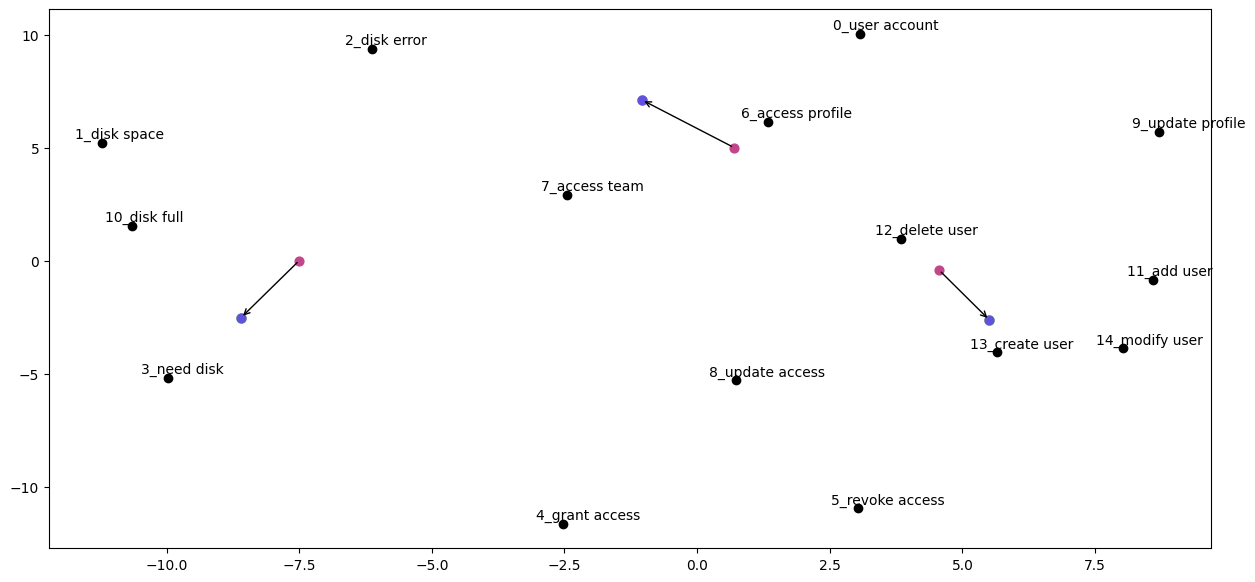

In [142]:
import random
r = lambda: random.randint(0,255)

def random_color():
    return '#%02X%02X%02X'%(r(),r(),r())

import matplotlib.pyplot as plt

iter_color = ['red','green','blue','cyan']
iter_color = []
for iter_num in range(-1,iters):
    iter_color.append(random_color())

pairs = word_pairs

plt.figure(figsize=(15,7))
for iter_num in range(-1,iters):
    #print('Iter num',iter_num)
    centroid_dict = centroids_in_time[iter_num]
    for j in centroid_dict.keys():
        plt.scatter(centroid_dict[j][0],centroid_dict[j][1],color=iter_color[iter_num],marker='o',s=40)
        #plt.text(centroid_dict[j][0]-0.5,centroid_dict[j][1]+0.2,str(j)+'_centroid_'+str(iter_num))

for key in centroid_in_time:
    centroid_list = centroid_in_time[key]
    #print(len(centroid_list))
    for i in range(len(centroid_list)-1):
        #print(i)
        plt.annotate('',
                     xy=(centroid_list[i+1][0],centroid_list[i+1][1]),
                     xytext=(centroid_list[i][0],centroid_list[i][1]),
                     arrowprops = dict(arrowstyle='->',color='black')
                    )

for i in range(X_transformed.shape[0]):
    plt.scatter(X_transformed[i,0],X_transformed[i,1],marker='o',color="black")
    plt.text(X_transformed[i,0]-0.5,X_transformed[i,1]+0.2, str(i)+"_"+pairs[i])

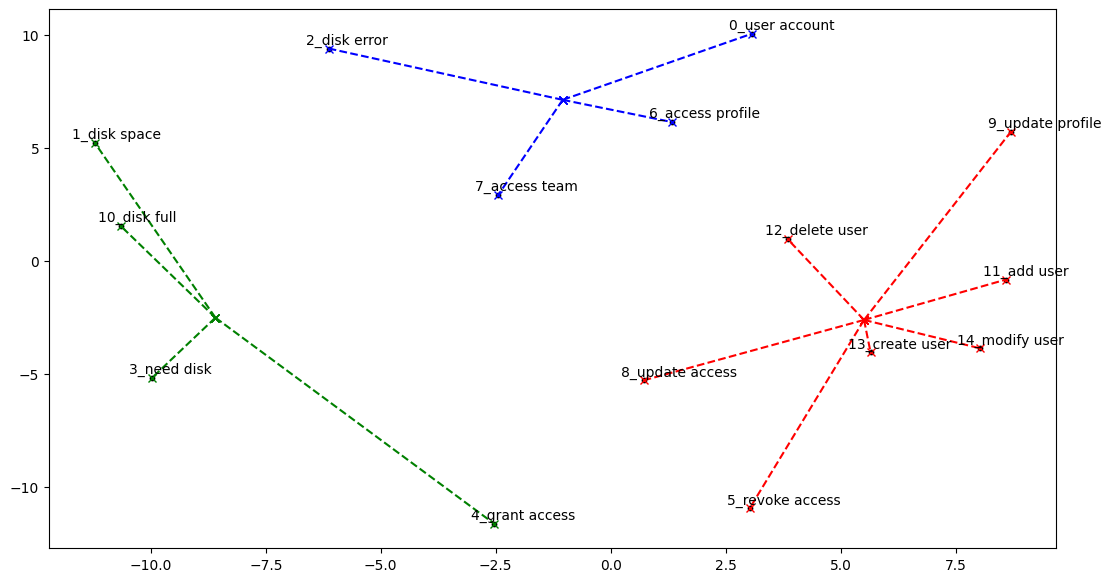

In [143]:
plt.figure(figsize=(13,7))

#for iter_num in range(-1,iters):
    #print('Iter num',iter_num)
#    centroid_dict = centroids_in_time[iter_num]
#    for j in centroid_dict.keys():
#        plt.scatter(centroid_dict[j][0],centroid_dict[j][1],color=iter_color[iter_num],marker='o',s=40)
#        plt.text(centroid_dict[j][0]-0.5,centroid_dict[j][1]+0.2,str(j)+'_centroid_'+str(iter_num))

#for key in centroid_in_time:
#    centroid_list = centroid_in_time[key]
#    #print(len(centroid_list))
#    for i in range(len(centroid_list)-1):
#        #print(i)
#        plt.annotate('',
#                     xy=(centroid_list[i+1][0],centroid_list[i+1][1]),
#                     xytext=(centroid_list[i][0],centroid_list[i][1]),
#                     arrowprops = dict(arrowstyle='->',color='black')
#                    )

for i in range(X_transformed.shape[0]):
    plt.scatter(X_transformed[i,0],X_transformed[i,1],marker='o',color="black",s=10)
    plt.text(X_transformed[i,0]-0.5,X_transformed[i,1]+0.2, str(i)+"_"+pairs[i])

clust_colors = ['red','green','blue']
for clust_key in cluster_dict.keys():
    cluster_list = cluster_dict[clust_key]
    for item in cluster_list:
        plt.plot([centroid_dict[clust_key][0],X_transformed[item,0]],
                 [centroid_dict[clust_key][1],X_transformed[item,1]],
                 color=clust_colors[clust_key],
                 linestyle='dashed',
                 marker='x')

In [144]:
labels = tickets_df['label'].to_list()

for key in cluster_dict.keys():
    print(f"------ Cluster {key} ------")
    for item in cluster_dict[key]:
        print(pairs[item])

------ Cluster 2 ------
user account
disk error
access profile
access team
------ Cluster 1 ------
disk space
need disk
grant access
disk full
------ Cluster 0 ------
revoke access
update access
update profile
add user
delete user
create user
modify user


In [145]:
labels = tickets_df['label'].to_list()

clust_label_map = {0:0, 1:1, 2:2}

pair_label_map = {}

for key in cluster_dict.keys():
    print(f"------ Cluster {key} ------")
    for item in cluster_dict[key]:
        #print(pairs[item])
        pair_label_map[pairs[item]] = clust_label_map[key]

------ Cluster 2 ------
------ Cluster 1 ------
------ Cluster 0 ------


In [146]:
pair_label_map

{'user account': 2,
 'disk error': 2,
 'access profile': 2,
 'access team': 2,
 'disk space': 1,
 'need disk': 1,
 'grant access': 1,
 'disk full': 1,
 'revoke access': 0,
 'update access': 0,
 'update profile': 0,
 'add user': 0,
 'delete user': 0,
 'create user': 0,
 'modify user': 0}

# 7. Create tickets labels using results of K-means clustering

In [147]:
def create_label_from_cluster(pair_label_map,
                              sentences):
    sent_dict = {}
    for i,sent in enumerate(sentences):
        sent_dict[i] = []
        sent_list = sent.split(' ')
        for pair in pair_label_map:
            items = pair.split(' ')
            if (items[0] in sent_list) and (items[1] in sent_list):
                sent_dict[i].append(pair_label_map[pair])
    #print(i+1)
    return sent_dict

In [148]:
sent_dict = create_label_from_cluster(pair_label_map,
                                      proc_desc)

In [149]:
len(sent_dict)

60

In [150]:
sent_labels = {}
for item in sent_dict:
    if len(sent_dict[item])==1:
        sent_labels[item] = sent_dict[item][0]
    else:
        ar = np.array(sent_dict[item])
        uniq_vals = np.unique(ar)
        freq,_ = np.histogram(ar,bins=len(uniq_vals))
        sent_labels[item] = uniq_vals[freq.argmax()]

In [151]:
len(sent_dict)

60

In [152]:
true_labels = tickets_df['label'].to_numpy()

In [153]:
pred_labels = np.array(list(sent_labels.values()))

In [154]:
pred_labels.shape

(60,)

In [155]:
tickets_df['gen_labels'] = pred_labels

In [156]:
tickets_df

,subject,description,key_phrase,label,preproc_description,preproc_subject,gen_labels
0,Grant Access to Confidential Files,Grant user access to confidential documents.,grant access,0,grant user access confidential document,grant access confidential file,1
1,Revoke Access to Sensitive Data,Revoke user access to sensitive information.,revoke access,0,revoke user access sensitive information,revoke access sensitive data,0
2,Update Access Profile,Modify my access profile to include admin rights,access profile,0,modify access profile include admin right,update access profile,2
3,Grant Access Request for New Project,Please grant access to project files for users...,grant access,0,please grant access project file user team,grant access request new project,1
4,Access Removal for Departing Employee,Revoke access for departing employee.,revoke access,0,revoke access departing employee,access removal departing employee,0
5,Profile Update for New Role,Update access profile to reflect new job respo...,access profile,0,update access profile reflect new job responsi...,profile update new role,0
6,Grant Temporary Access,Grant temporary access to contractor.,grant access,0,grant temporary access contractor,grant temporary access,1
7,Revoke Admin Access,Revoke admin access for a user.,revoke access,0,revoke admin access user,revoke admin access,0
8,Access Level Update,update access profile with more levels for sal...,access profile,0,update access profile level sale team,access level update,0
9,Grant Access Request for Training,Need to grant access to training materials.,grant access,0,need grant access training material,grant access request training,1


# 8 Create Classifiers

<b>8.1 Create train and test data</b>

In [157]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [159]:
sent_embeds = phrase_model.encode(preproc_desc)

In [158]:
from sklearn.model_selection import train_test_split

In [224]:
X_train, X_test, y_train, y_test = train_test_split(sent_embeds, 
                                                    pred_labels,
                                                    stratify=pred_labels,
                                                    test_size=0.33,
                                                    random_state=42
                                                   )

<b>8.2 Create Logistic Regression</b>

In [225]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [227]:
y_pred

array([1, 0, 2, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0])

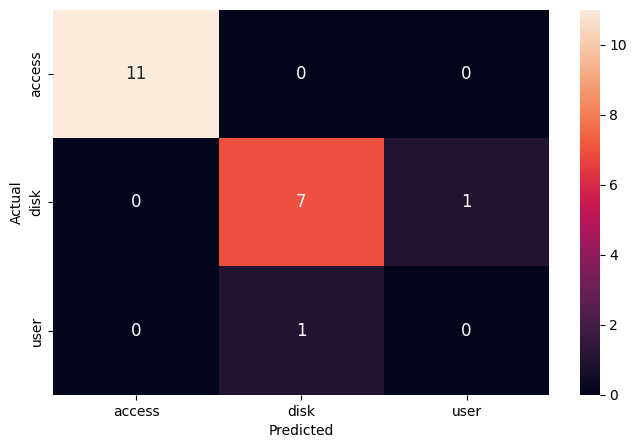

In [228]:
import seaborn as sns
font_size = 12
label_class = ['access','disk','user']
cl_rep = classification_report(y_test,
                               y_pred,
                               target_names=label_class,
                               output_dict=True
                            )
df = pd.DataFrame(cl_rep)
df.head()

cm = confusion_matrix(y_test,
                      y_pred)

plt.figure(figsize = (8, 5))
sns.heatmap(cm,
            xticklabels=label_class,
            yticklabels=label_class,
            annot = True,  fmt = '.0f',
            annot_kws={'size': font_size})
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [229]:
df

,access,disk,user,accuracy,macro avg,weighted avg
precision,1.0,0.875,0.0,0.9,0.625,0.9
recall,1.0,0.875,0.0,0.9,0.625,0.9
f1-score,1.0,0.875,0.0,0.9,0.625,0.9
support,11.0,8.000,1.0,0.9,20.000,20.0


In [230]:
sent_embeds.shape

(60, 768)

<b>8.3 Deep Neural Network</b>

In [231]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Flatten, LeakyReLU, Conv2D, MaxPooling2D, Dense, Dropout, Activation, BatchNormalization, LayerNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import to_categorical

In [232]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [233]:
y_test_cat[0]

array([0., 1., 0.], dtype=float32)

In [234]:
def nn_model(lr=0.1):
    model = Sequential()
    # Add layers as per the architecture mentioned above in the same sequence
    model.add(InputLayer((768,)))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64,activation='relu'))
    #model.add(BatchNormalization())
    model.add(Dense(32,activation='relu'))
    #model.add(BatchNormalization())
    model.add(Dense(3,activation='softmax'))
    # Compile the model
    model.compile(loss=categorical_crossentropy,
                  metrics=['accuracy'],
                  optimizer=Adam(learning_rate=lr))

    return model

In [238]:
num_epochs = 50
batch_size = 128

seq_model = nn_model(lr=0.01)
seq_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 256)               196864    
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_26 (Dense)            (None, 128)               32896     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_27 (Dense)            (None, 64)                8256      
                                                                 
 dense_28 (Dense)            (None, 32)                2080      
                                                                 
 dense_29 (Dense)            (None, 3)                

In [239]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [245]:
checkpoint = ModelCheckpoint("best_model.h5",
                            monitor='val_accuracy',
                            verbose=1,
                            save_best_only=True,
                            mode='max')

history = seq_model.fit(X_train,
                        y_train_cat,
                        validation_data=[X_test,y_test_cat],
                        epochs = num_epochs,
                        batch_size = batch_size,
                        callbacks=[checkpoint],
                        verbose=1)

Epoch 1/50
1/1 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.90000, saving model to best_model.h5
1/1 [==============================] - 0s 142ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.6021 - val_accuracy: 0.9000
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 0.0186 - accuracy: 0.9750
Epoch 2: val_accuracy did not improve from 0.90000
1/1 [==============================] - 0s 57ms/step - loss: 0.0186 - accuracy: 0.9750 - val_loss: 0.6093 - val_accuracy: 0.9000
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 3.2221e-04 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.90000
1/1 [==============================] - 0s 44ms/step - loss: 3.2221e-04 - accuracy: 1.0000 - val_loss: 0.6187 - val_accuracy: 0.9000
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 1.3597e-04 - accuracy: 1.0000
Epoch 4: val_accuracy did not improve from 0.90000

Text(0.5, 1.0, 'Deep NN')

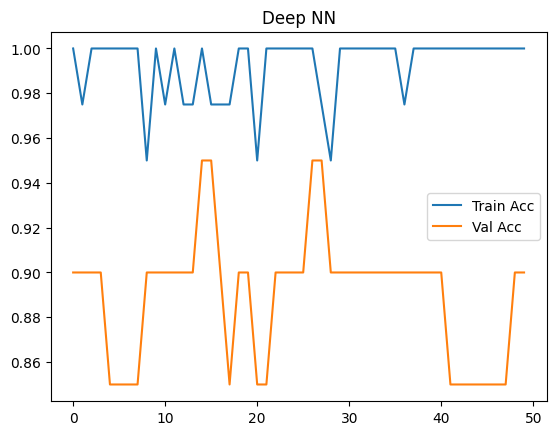

In [246]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train Acc','Val Acc'])
plt.title('Deep NN')

In [242]:
from tensorflow.keras.saving import load_model
best_model = load_model("best_model.h5")
test_pred_logits = best_model.predict(X_test)
test_pred_labels = np.argmax(test_pred_logits, axis = -1)

1/1 [==============================] - 0s 47ms/step


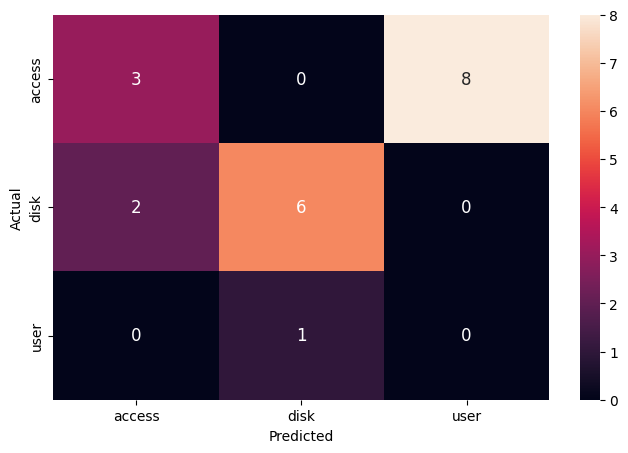

In [243]:
cl_rep = classification_report(y_test,
                               test_pred_labels,
                               target_names=label_class,
                               output_dict=True
                            )
df_nn = pd.DataFrame(cl_rep)

cm = confusion_matrix(y_test,
                      test_pred_labels)

plt.figure(figsize = (8, 5))
sns.heatmap(cm,
            xticklabels=label_class,
            yticklabels=label_class,
            annot = True,  fmt = '.0f',
            annot_kws={'size': font_size})
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [244]:
df_nn

,access,disk,user,accuracy,macro avg,weighted avg
precision,0.600000,0.857143,0.0,0.45,0.485714,0.672857
recall,0.272727,0.750000,0.0,0.45,0.340909,0.450000
f1-score,0.375000,0.800000,0.0,0.45,0.391667,0.526250
support,11.000000,8.000000,1.0,0.45,20.000000,20.000000
